In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.datasets.cifar10 import load_data

C:\Users\ASUS\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def discriminator():
  model=Sequential()
  model.add(Conv2D(64,(3,3),padding='same',input_shape=(32,32,3)))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))
  opt=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

In [3]:
def generator(latent_dim):
  model=Sequential()
  model.add(Dense(256*4*4,input_dim=latent_dim))
  model.add(Reshape((4,4,256)))
  model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
  return model

In [4]:
def gan(g,d):
  d.trainable=False
  model=Sequential()
  model.add(g)
  model.add(d)
  opt=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

In [5]:
(trainX,_),(_,_)=load_data()
data=trainX.astype('float32')
data=(trainX-127.5)/127.5
def load_real_data(S):
    idx=np.random.randint(0,data.shape[0],S)
    x_real=data[idx]
    return x_real,np.ones((S,1))

In [6]:
def gen_latent_points(S,n):
  return np.random.randn(S,n)

In [7]:
def load_fake_data(g,S,n=100):
  x_input=gen_latent_points(S,n)
  x=g.predict(x_input)
  y=np.zeros((S,1))
  return x,y

In [8]:
def train_discriminator(model,g,s):
  x_real,y_real=load_real_data(s)
  x_fake,y_fake=load_fake_data(g,s)
  _,a1=model.train_on_batch(x_real,y_real)
  _,a2=model.train_on_batch(x_fake,y_fake)
  return a1,a2

In [9]:
def train_gan(g,d,g1,df,latent_dim,n_epochs=500,batch_size=128):
  n_batch=df.shape[0]//batch_size
  s=batch_size//2
  for i in range(n_epochs):
    for j in range(n_batch):
        print(j)
        a1,a2=train_discriminator(d,g,s)
        x_gan=gen_latent_points(batch_size,latent_dim)
        y_gan=np.ones((batch_size,1))
        _,a=g1.train_on_batch(x_gan,y_gan)
    print(i+1,a1,a2,a)
    if i%10==0:
        g.save('generator.h5')
        d.save('discriminator.h5')
        g1.save('gan.h5')
        generated_image = g.predict(x_gan)
        generated_image = (generated_image + 1) / 2.0
        for k in range(25):
          plt.subplot(5,5,k+1)
          plt.imshow(generated_image[k])
        plt.savefig(f'gan_generated_image_epoch_{i+1}.jpg', bbox_inches='tight', pad_inches=0)

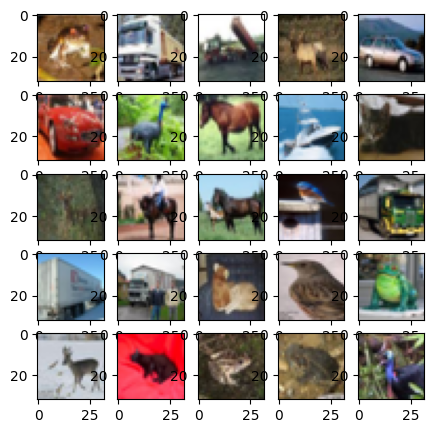

In [5]:
plt.figure(figsize=(5,5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(trainX[i])

0
2/2 [==============================] - 9s 8ms/step
1
2/2 [==============================] - 0s 18ms/step
2
2/2 [==============================] - 0s 12ms/step
3
2/2 [==============================] - 0s 15ms/step
4
2/2 [==============================] - 0s 14ms/step
5
2/2 [==============================] - 0s 16ms/step
6
2/2 [==============================] - 0s 13ms/step
7
2/2 [==============================] - 0s 13ms/step
8
2/2 [==============================] - 0s 8ms/step
9
2/2 [==============================] - 0s 8ms/step
10
2/2 [==============================] - 0s 12ms/step
11
2/2 [==============================] - 0s 13ms/step
12
2/2 [==============================] - 0s 9ms/step
13
2/2 [==============================] - 0s 11ms/step
14
2/2 [==============================] - 0s 9ms/step
15
2/2 [==============================] - 0s 7ms/step
16
2/2 [==============================] - 0s 7ms/step
17
2/2 [==============================] - 0s 8ms/step
18
2/2 [====================

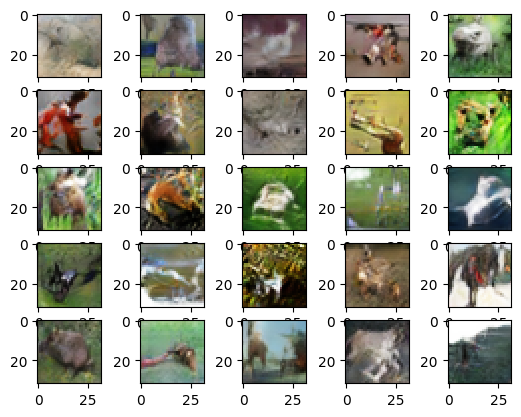

In [3]:
g = generator(100)
d = discriminator()
g1 = gan(g, d)
train_gan(g, d, g1, data, 100)

In [4]:
g.save('generator.h5')
d.save('discriminator.h5')
g1.save('gan.h5')

In [6]:
g=keras.models.load_model('generator.h5')
d=keras.models.load_model('discriminator.h5')
g1=keras.models.load_model('gan.h5')

(trainX,_),(_,_)=load_data()
data=trainX.astype('float32')
data=(trainX-127.5)/127.5
def load_real_data(S):
    idx=np.random.randint(0,data.shape[0],S)
    x_real=data[idx]
    return x_real,np.ones((S,1))

def gen_latent_points(S,n):
  return np.random.randn(S,n)

def load_fake_data(g,S,n=100):
  x_input=gen_latent_points(S,n)
  x=g.predict(x_input)
  y=np.zeros((S,1))
  return x,y

def train_discriminator(model,g,s):
  x_real,y_real=load_real_data(s)
  x_fake,y_fake=load_fake_data(g,s)
  _,a1=model.train_on_batch(x_real,y_real)
  _,a2=model.train_on_batch(x_fake,y_fake)
  return a1,a2

def train_gan(g,d,g1,df,latent_dim,n_epochs=101,batch_size=128):
  n_batch=df.shape[0]//batch_size
  s=batch_size//2
  for i in range(n_epochs):
    for j in range(n_batch):
        print(j)
        a1,a2=train_discriminator(d,g,s)
        x_gan=gen_latent_points(batch_size,latent_dim)
        y_gan=np.ones((batch_size,1))
        _,a=g1.train_on_batch(x_gan,y_gan)
    print(i+1,a1,a2,a)
    if i%10==0:
        g.save('generator.h5')
        d.save('discriminator.h5')
        g1.save('gan.h5')
        generated_image = g.predict(x_gan)
        generated_image = (generated_image + 1) / 2.0
        for k in range(25):
          plt.subplot(5,5,k+1)
          plt.imshow(generated_image[k])
        plt.savefig(f'gan_generated_image_epoch_{i+1}.jpg', bbox_inches='tight', pad_inches=0)

0
2/2 [==============================] - 8s 18ms/step
1
2/2 [==============================] - 0s 7ms/step
2
2/2 [==============================] - 0s 14ms/step
3
2/2 [==============================] - 0s 20ms/step
4
2/2 [==============================] - 0s 5ms/step
5
2/2 [==============================] - 0s 7ms/step
6
2/2 [==============================] - 0s 18ms/step
7
2/2 [==============================] - 0s 6ms/step
8
2/2 [==============================] - 0s 16ms/step
9
2/2 [==============================] - 0s 13ms/step
10
2/2 [==============================] - 0s 5ms/step
11
2/2 [==============================] - 0s 8ms/step
12
2/2 [==============================] - 0s 12ms/step
13
2/2 [==============================] - 0s 5ms/step
14
2/2 [==============================] - 0s 6ms/step
15
2/2 [==============================] - 0s 20ms/step
16
2/2 [==============================] - 0s 5ms/step
17
2/2 [==============================] - 0s 8ms/step
18
2/2 [======================

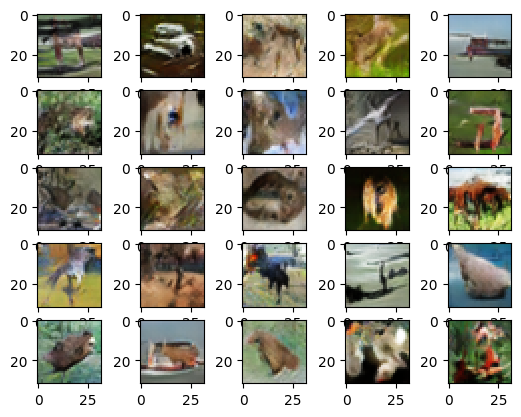

In [3]:
train_gan(g, d, g1, data, 100)

1/1 [==============================] - 0s 128ms/step


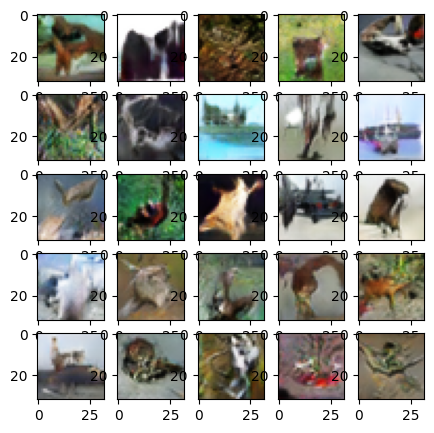

In [43]:
plt.figure(figsize=(5,5))
x=np.random.randn(25,100)
img=g.predict(x)
img=(img+1)/2.0
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(img[i])